In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

%matplotlib inline
sns.set_theme(style="white")

In [31]:
def etgw(L, grad_L, x_init, y_init, lr, epsilon=0.00001, max_iter = 100000): 
    """
    Explicit Twisted Gradient Descent (ETGD)

    This function implements the ETGD algorithm from
    Essid, Tabak, and Trigila (2019). 
    Notably, the optimization here is: 

            min_x max_y L(x, y)

    Inputs: 
        - L: the loss function, should take x and y as arguments
        - grad_L: the gradient of L, should be a vector of 2 functions that takes x and y as arguments
        - x_init: the initial value of x
        - y_init: the initial value of y
        - lr: the learning rate
        - epsilon: the stopping criterion
        - max_iter: the maximum number of iterations
    
    Outputs: 
        - x: the final value of x
        - y: the final value of y
        - x_list: a list of all x values
        - y_list: a list of all y values
    """
    # set initial values
    x = x_init
    y = y_init
    x_list = [x]
    y_list = [y]
    grad_list = [np.linalg.norm(np.array([grad_L[0](x, y), grad_L[1](x, y)]))]
    iter = 0
    # iterate until convergence
    while iter < max_iter: 
        iter += 1
        x_prev = x
        y_prev = y
        x = x_prev - lr * grad_L[0](x_prev, y_prev)
        y = y_prev + lr * grad_L[1](x_prev, y_prev)
        x_list.append(x)
        y_list.append(y)
        # check for convergence
        norm_grad = np.linalg.norm(np.array([grad_L[0](x, y), grad_L[1](x, y)]))
        grad_list.append(norm_grad)
        if norm_grad < epsilon: 
            print("Converged on iteration " + str(iter))
            break
    return x, y, np.array(x_list), np.array(y_list), np.array(grad_list)

def itgw(L, grad_L, hessian_L, x_init, y_init, lr, epsilon=0.0001, max_iter = 500, verbose=False): 
    """
    Implicit Twisted Gradient Descent (ETGD)

    This function implements the ITGD algorithm from
    Essid, Tabak, and Trigila (2019). This differs from the 
    explicit version in that we leverage (an approximation of) the 
    gradient at the future location. 

    Notably, the optimization here is: 

            min_x max_y L(x, y)

    Inputs: 
        - L: the loss function, should take x and y as arguments
        - grad_L: should output be a vector of 2 functions that takes x and y as arguments
        - hessian_L: should output a 2x2 matrix of functions that takes x and y as arguments
        - x_init: the initial value of x
        - y_init: the initial value of y
        - lr: the learning rate
        - epsilon: the stopping criterion
        - max_iter: the maximum number of iterations
    
    Outputs: 
        - x: the final value of x
        - y: the final value of y
        - x_list: a list of all x values
        - y_list: a list of all y values
    """
    # set initial values
    x = x_init
    y = y_init
    x_list = [x[0]]
    y_list = [y[0]]
    z = np.array([x, y]).flatten()
    grad_list = [np.linalg.norm(grad_L(z))]
    iter = 0
    # iterate until convergence
    while iter < max_iter: 
        iter += 1
        if verbose: 
            print("z:", z)
            print("J:", np.eye(2))
            print("Hessian:", hessian_L(z))
            print("Gradient:", grad_L(z))
        z = z - lr * (np.eye(2) + lr * np.linalg.inv(hessian_L(z))) @ grad_L(z)
        x_list.append(z[0])
        y_list.append(z[1])
        # check for convergence
        norm_grad = np.linalg.norm(grad_L(z))
        grad_list.append(norm_grad)
        if norm_grad < epsilon: 
            print("Converged on iteration " + str(iter))
            break
    return z[0], z[1], np.array(x_list), np.array(y_list), np.array(grad_list)

Set up our toy example function and visualize its landscape. 

In [1]:
def hyperbolic_L(x, y): 
    return x ** 2 - y ** 2

def hyperbolic_grad_L(x, y): 
    return np.array([2 * x, -2 * y])

def hyperbolic_hessian_L(x, y): 
    return np.array([[2, 0], [0, -2]])

In [2]:
def toy_exp_term(x, y): 
    return np.exp(-(x - 0.5)**2 - (y - 0.75)**2)

def toy_L(x, y): 
    return (x - 0.5) * (y - 0.5) + (1/3) * toy_exp_term(x, y)

def toy_grad_L_x(x, y): 
    return (y - 0.5) - (2/3) * (x - 0.5) * toy_exp_term(x, y)

def toy_grad_L_y(x, y): 
    return (x - 0.5) - (2/3) * (y - 0.75) * toy_exp_term(x, y)

def toy_hessian_L_xx(x, y):
    return (-2/3) * toy_exp_term(x, y) * (-2 * x**2 + 2 * x + 0.5)

def toy_hessian_L_xy(x, y): 
    return 1 + (4/3) * (x - 0.5) * (y - 0.75) * toy_exp_term(x, y)

def toy_hessian_L_yy(x, y): 
    return (-2/3) * toy_exp_term(x, y) * (-2 * y**2 + 3 * y - 0.125)

def toy_grad(z): 
    return np.array([toy_grad_L_x(z[0], z[1]), toy_grad_L_y(z[0], z[1])])

def toy_hess(z): 
    return np.array([[toy_hessian_L_xx(z[0], z[1]), toy_hessian_L_xy(z[0], z[1])], [toy_hessian_L_xy(z[0], z[1]), toy_hessian_L_yy(z[0], z[1])]])

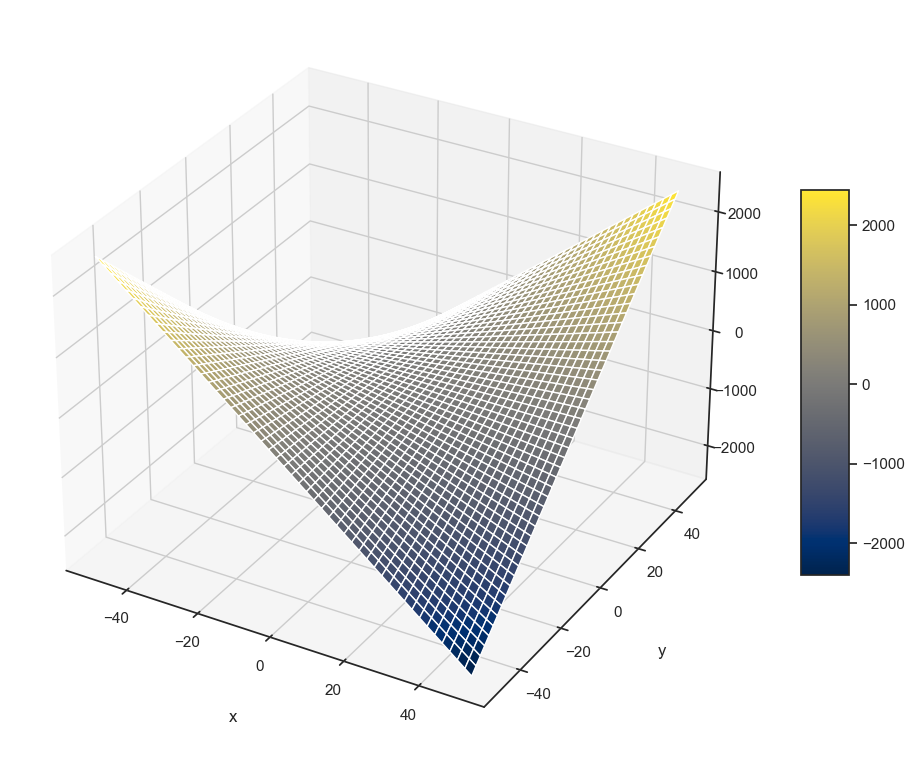

In [52]:


plot_3D(toy_L)

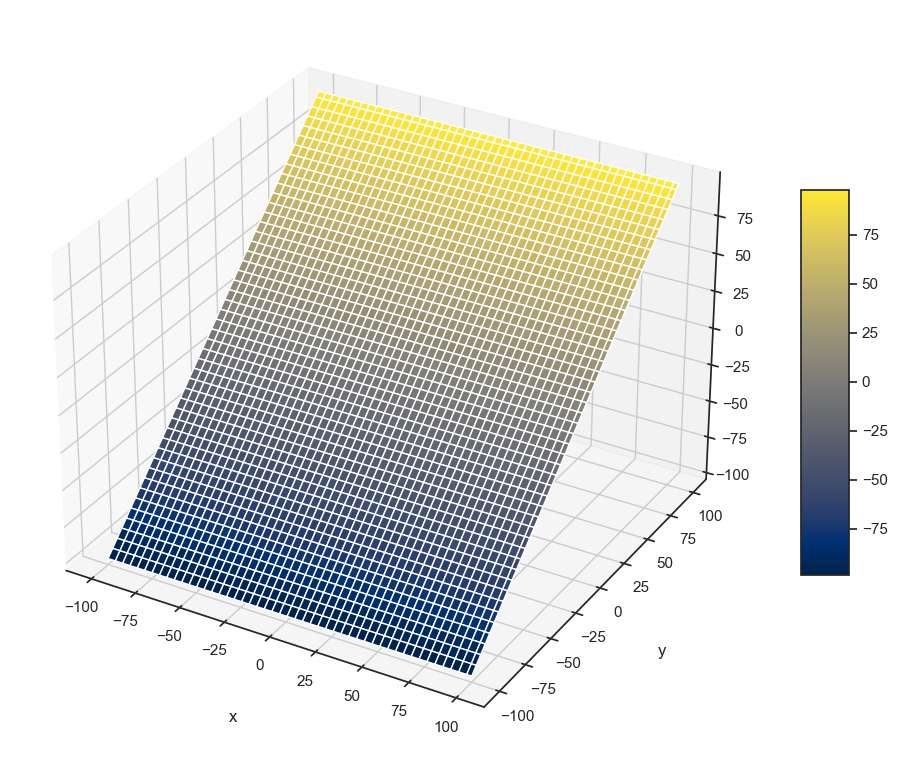

In [5]:
# visualize the gradient with respect to x
plot_3D(toy_grad_L_x)

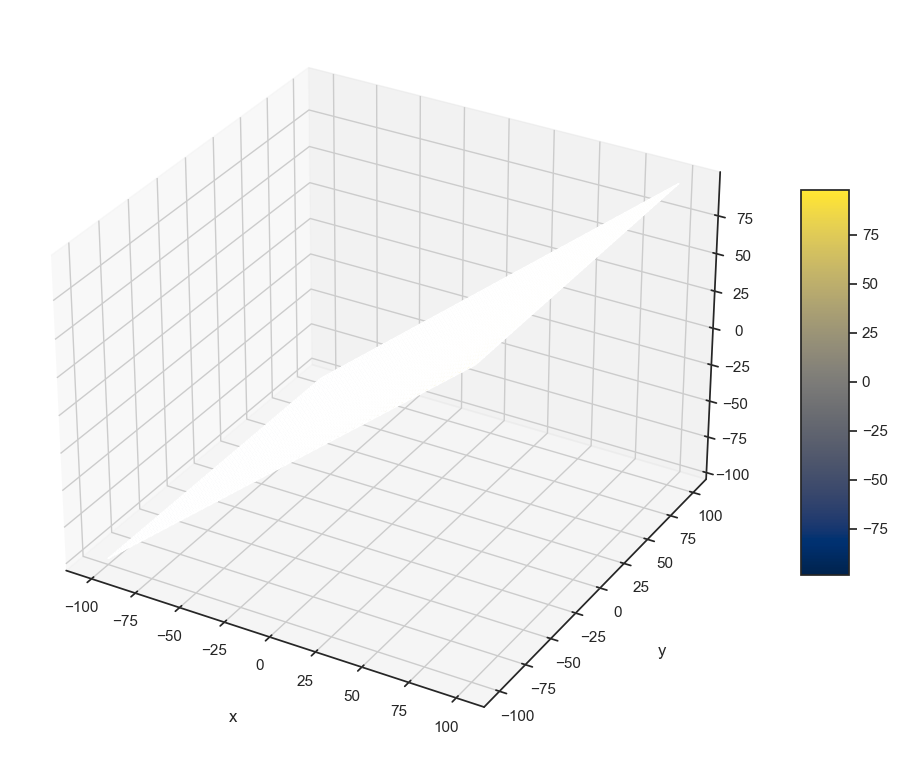

In [6]:
# visualize the gradient with respect to y
plot_3D(toy_grad_L_y)

In [16]:
def vis_plot(y_list, y_axis_title = "Gradient Norm", x_axis_title = "Iteration", x_list = None): 
    """
    Produce a line plot based on the given y values. Primary use case is for visualizing the gradient norm
    over iterations of an optimization procedure, in order to determine convergence. 
    """
    if x_list is None: 
        x_list = np.arange(len(y_list))
    y_list = np.array(y_list)
    plt.plot(x_list, y_list)
    plt.xlabel(x_axis_title)
    plt.ylabel(y_axis_title)
    plt.show()

### Experiments

Checking the change in the gradient norm v.s. iteration. 

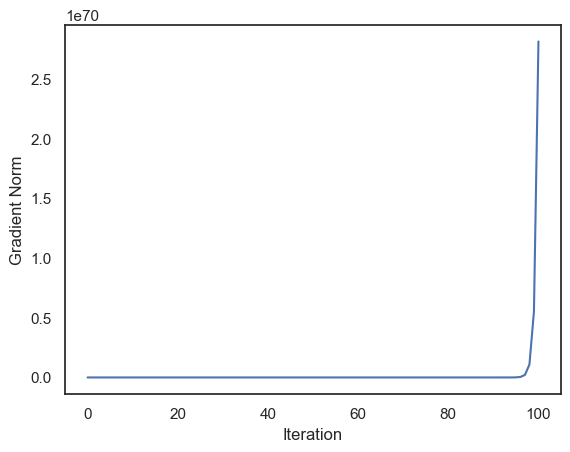

In [32]:
np.random.seed(69)
x_init = np.random.rand(1)
y_init = np.random.rand(1)
x, y, x_list, y_list, grad_list = etgw(toy_L, [toy_grad_L_x, toy_grad_L_y], x_init, y_init, 5, max_iter=100)
vis_plot(grad_list)
# result: the naive implementation of ITGD does not converge. 

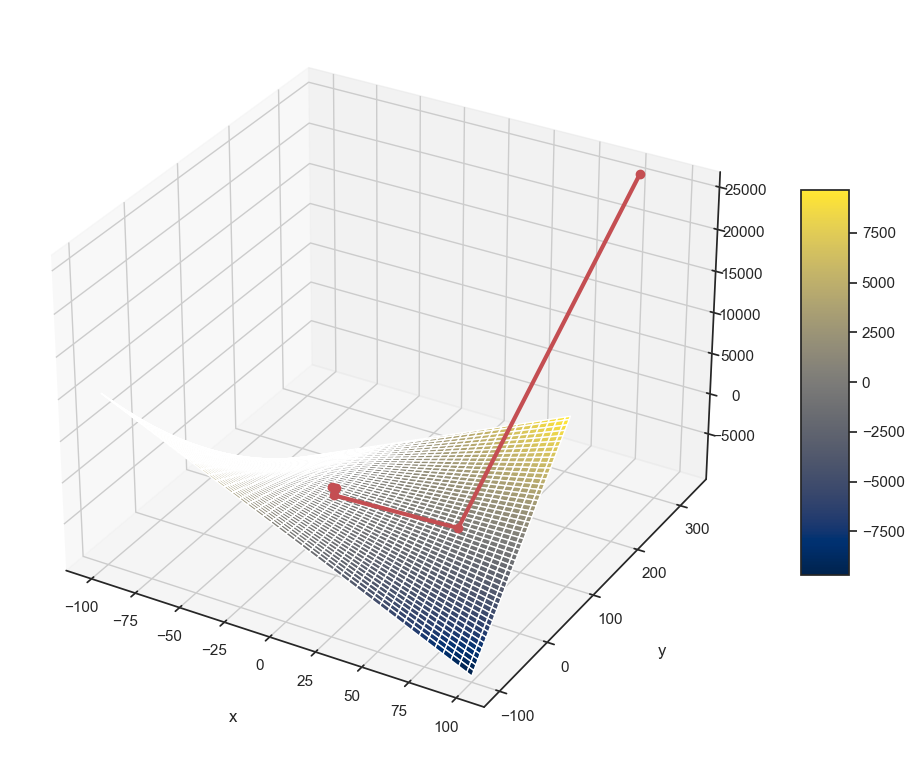

In [9]:
# quickly diverged... 
plot_3D(toy_L, x_list[:5], y_list[:5])

In [10]:
def run_trials(TRIALS, f = toy_L, grad_f = [toy_grad_L_x, toy_grad_L_y]): 
    np.random.seed(0)
    TRIALS = 100
    x_init = np.random.randint(0, 1, TRIALS)
    y_init = np.random.randint(0, 1, TRIALS)
    x_opts = []
    y_opts = []

    for trial in range(TRIALS):
        x_optim, y_optim, _, _, _ = etgw(f, grad_f, x_init[trial], y_init[trial], 0.1, epsilon=0.00001, max_iter = 1000) 
        x_opts.append(x_optim)
        y_opts.append(y_optim)
    return x_opts, y_opts

In [11]:
def visualize_optimal_points(x_values, y_values):
    """
    Visualize the distribution of optimal points found by ITGD over multiple trials.
    Inputs: 
        x_values: list of x values of optimal points
        y_values: list of y values of optimal points
    """
    grid_size = 2  # Size of the grid
    resolution = 100  # Resolution of the heatmap (higher values give smoother results)
    
    # Create a grid
    grid = np.zeros((resolution, resolution))
    x_grid = np.linspace(0, grid_size, resolution)
    y_grid = np.linspace(0, grid_size, resolution)
    X, Y = np.meshgrid(x_grid, y_grid)
    
    # Compute the density of optimal points on the grid
    for x, y in zip(x_values, y_values):
        # Find the nearest grid cell
        x_index = np.argmin(np.abs(x_grid - x))
        y_index = np.argmin(np.abs(y_grid - y))
        
        # Increment the density at that grid cell
        grid[y_index, x_index] += 1
    
    # Plot the heatmap
    plt.imshow(grid, cmap='hot', origin='lower', extent=[0, grid_size, 0, grid_size])
    plt.colorbar(label='Optimal Points Density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Optimal Points Heatmap')
    plt.show()

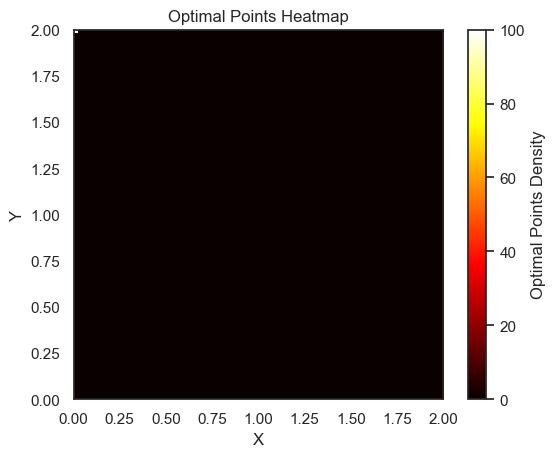

In [12]:
visualize_optimal_points(*run_trials(100))

Optimal point: (4.904382888581205e+18, -4.904382888581205e+18)
Trajectory:  [(3.0, 3.0), (2.868752101263071, 2.868752125423821), (2.7443989229531427, 2.7443989867238736), (2.626584700238891, 2.626584766937541), (2.514978666210103, 2.5149784637991557), (2.40927744262808, 2.409275992000216), (2.309207576279435, 2.309202189780177), (2.214527186065185, 2.2145116365912703), (2.1250256241509953, 2.1249871999293313), (2.0405204502940117, 2.0404357419586847), (1.9608517448390652, 1.9606812654405468), (1.885874506206515, 1.8855565599418198), (1.815450289624908, 1.8148947624970466), (1.749439282409665, 1.7485221128081634), (1.687693811298138, 1.6862527707384805), (1.63005397567172, 1.6278861051193965), (1.5763457450602547, 1.573206459952028), (1.5263814722805817, 1.5219850720496508), (1.4799624175475827, 1.473983570232682), (1.4368826384588766, 1.4289583645890571), (1.3969335250259665, 1.3866652501289667), (1.3599083349782892, 1.3468636767307267), (1.3256062550159828, 1.309320322737553), (1.2938

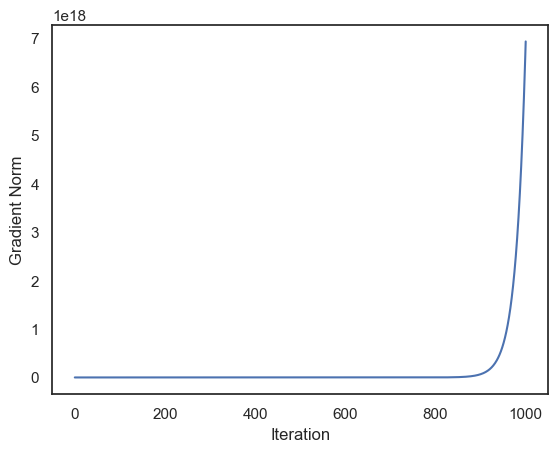

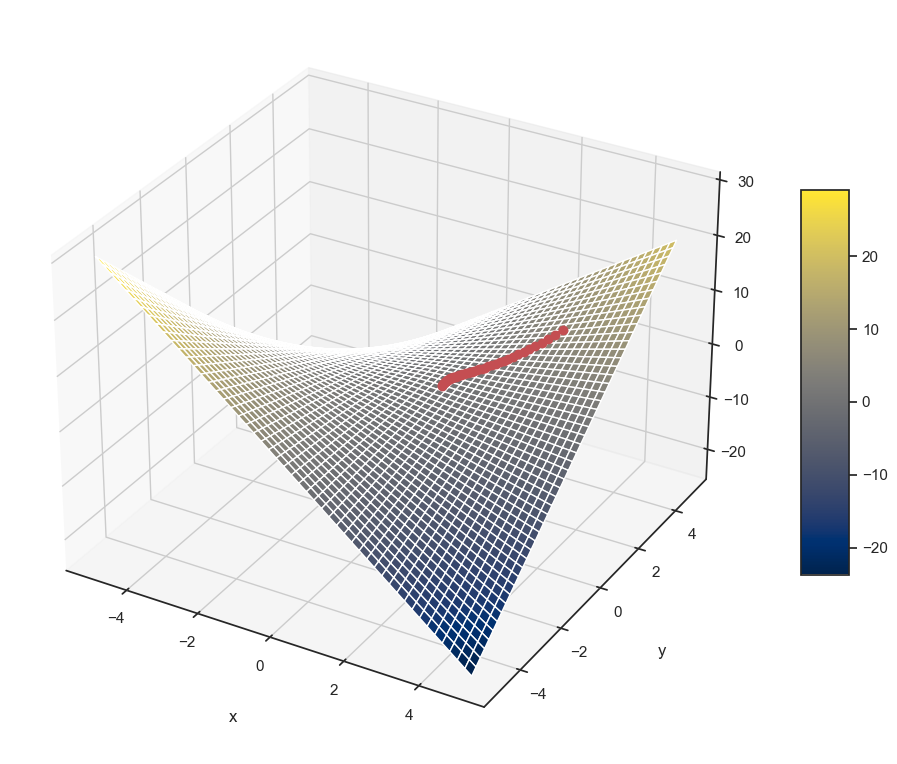

In [82]:
np.random.seed(69)
# set initial conditions and learning rate
x_init = np.array([3])
y_init = np.array([3])
learning_rate = 0.05
x, y, x_list, y_list, grad_list = itgw(toy_L, toy_grad, toy_hess, x_init, y_init, learning_rate, max_iter=1000)
# display the optimal point
print("Optimal point: ({}, {})".format(x, y))
# display the trajectory in list form
print("Trajectory: ", [(x, y) for x, y in zip(x_list, y_list)])
# visualize the change in gradient norm over iterations
vis_plot(grad_list)
# visualize the trajectory of the optimization algorithm over the function space
plot_3D(toy_L, x_list[:50], y_list[:50], grid = [[-5, 5], [-5, 5]], fineness = 0.02)

In [80]:
toy_L(x, y)

-12.70267516391328

In [77]:
toy_L(x_list[40], y_list[40])

0.42004775169803377

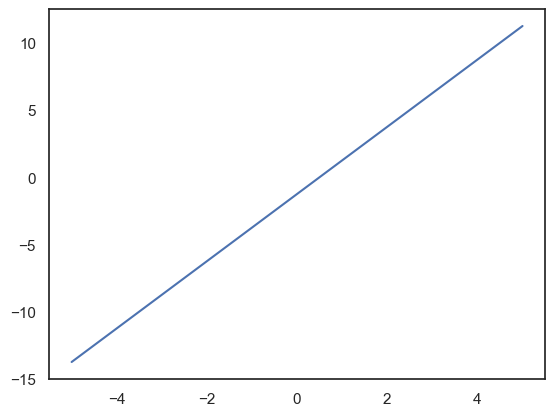

In [84]:
x = np.linspace(-5, 5, 100)
y = toy_L(x, 3)
plt.plot(x, y)